In [1]:
use_cuda = True
import os
os.chdir("/data/yosef2/users/chenling/HarmonizationSCANVI")
import sys
sys.path.append("/data/yosef2/users/chenling/HarmonizationSCANVI")
from umap import UMAP

from sklearn.neighbors import KNeighborsClassifier
from scvi.harmonization.utils_chenling import get_matrix_from_dir,SubsetGenes
from scvi.dataset.pbmc import PbmcDataset
from scvi.harmonization.utils_chenling import assign_label
import numpy as np
from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.harmonization.utils_chenling import run_model
from copy import deepcopy

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
from scvi.dataset.dataset import SubsetGenes

from scvi.metrics.clustering import select_indices_evenly
from umap import UMAP

from scvi.models.vae import VAE
from scvi.models.scanvi import SCANVI
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer,SemiSupervisedTrainer
import torch
import os


In [2]:
dataset1 = PbmcDataset(filter_out_de_genes=False)
dataset1.update_cells(dataset1.batch_indices.ravel()==0)
dataset1.subsample_genes(dataset1.nb_genes)

save_path='/data/yosef2/scratch/chenling/scanvi_data/'
count, geneid, cellid = get_matrix_from_dir(save_path + 'cite')
count = count.T.tocsr()
seurat = np.genfromtxt(save_path + 'cite/cite.seurat.labels', dtype='str', delimiter=',')
cellid = np.asarray([x.split('-')[0] for x in cellid])
labels_map = [0, 0, 1, 2, 3, 4, 5, 6]
labels = seurat[1:, 4]
cell_type = ['CD4 T cells', 'NK cells', 'CD14+ Monocytes', 'B cells','CD8 T cells', 'FCGR3A+ Monocytes', 'Other']
dataset2 = assign_label(cellid, geneid, labels_map, count, cell_type, seurat)
set(dataset2.cell_types).intersection(set(dataset2.cell_types))

dataset1.subsample_genes(dataset1.nb_genes)
dataset2.subsample_genes(dataset2.nb_genes)
gene_dataset = GeneExpressionDataset.concat_datasets(dataset1, dataset2)


File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 21425 genes
Downsampling from 8381 to 8381 cells
File data/10X/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 19773 genes
Downsampling from 4340 to 4340 cells
Keeping 19039 genes
Downsampling from 12721 to 11990 cells
Downsampling from 19039 to 19036 genes
Downsampling from 11990 to 11990 cells
Downsampling from 11990 to 7982 cells


/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:447: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:515: RuntimeWarning: Degrees of freedom <= 0 for slice
  return N.ndarray.var(self, axis, dtype, out, ddof, keepdims=True)._collapse(axis)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib

Downsampling from 19036 to 19011 genes
Downsampling from 7982 to 7982 cells
Downsampling from 19011 to 19011 genes
Downsampling from 7982 to 7982 cells
Downsampling from 17014 to 16980 genes
Downsampling from 6616 to 6616 cells
Keeping 14956 genes


In [3]:
celltype1='NK cells'
celltype2 = 'B cells'
pbmc = deepcopy(dataset1)
newCellType = [k for i, k in enumerate(dataset1.cell_types) if k not in [celltype1, 'Other']]
pbmc.filter_cell_types(newCellType)
pbmc2 = deepcopy(dataset2)
newCellType = [k for i, k in enumerate(dataset2.cell_types) if k not in [celltype2, 'Other']]
pbmc2.filter_cell_types(newCellType)
gene_dataset = GeneExpressionDataset.concat_datasets(pbmc, pbmc2)
rmCellTypes = '.'+celltype1.replace(' ', '')+'.'+celltype2.replace(' ', '')
pbmc, pbmc2, gene_dataset = SubsetGenes(pbmc, pbmc2, gene_dataset, 'UniquePops' + rmCellTypes.replace(' ', ''))

Downsampling from 7982 to 7351 cells
Downsampling from 6616 to 5907 cells
Keeping 14956 genes
Downsampling from 19011 to 1502 genes
Downsampling from 7351 to 7351 cells
Downsampling from 16980 to 1502 genes
Downsampling from 5907 to 5907 cells
Downsampling from 14956 to 1502 genes
Downsampling from 13258 to 13258 cells


In [4]:
len(gene_dataset.cell_types)

8

In [6]:
rep=0
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
if os.path.isfile('../UniquePops/vae.%s.pkl' % (rmCellTypes)):
    trainer.model.load_state_dict(torch.load('../UniquePops/vae.%s.pkl' % (rmCellTypes)))
    trainer.model.eval()
else:
    trainer.train(n_epochs=150)
    torch.save(trainer.model.state_dict(), '../PopRemove/vae.%s.pkl' % (rmCellTypes))
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, _, _ = full.sequential().get_latent()
batch_indices = gene_dataset.batch_indices.ravel()


In [7]:
latent_u = UMAP(spread=2).fit_transform(latent)

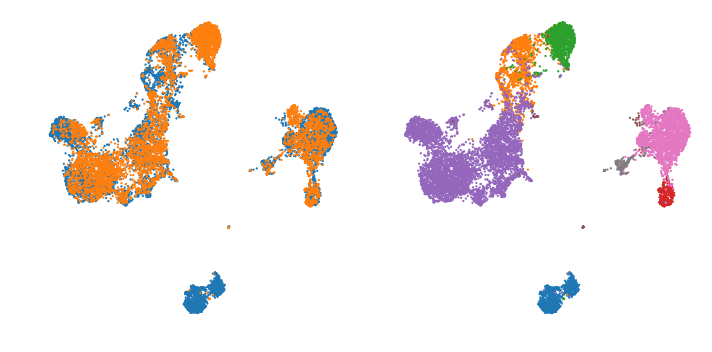

In [9]:
labels = gene_dataset.labels.ravel()
plt.figure(figsize=(10, 5))
plt.subplot(121)
for i,x in enumerate([0,1]):
    idx = (batch_indices==x)
    plt.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',s=5)
        
plt.axis("off")
# plt.legend()
plt.tight_layout()

plt.subplot(122)
for i,x in enumerate(np.unique(labels)):
    idx = (labels==x)
    plt.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',s=5)
        
plt.axis("off")
# plt.legend()
plt.tight_layout()

plt.savefig('Nclasses.latent0_u.pdf')

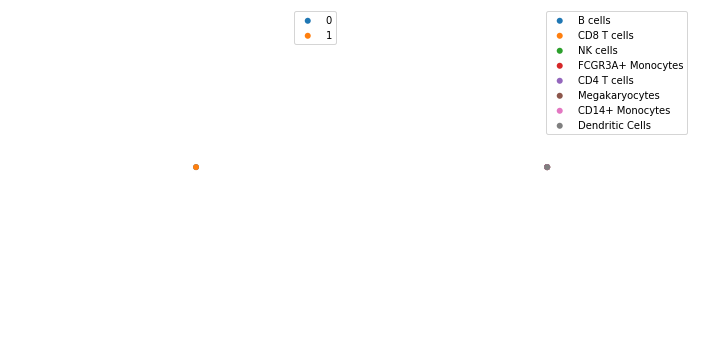

In [10]:
labels = gene_dataset.labels.ravel()
plt.figure(figsize=(10, 5))
plt.subplot(121)
for i,x in enumerate([0,1]):
    idx = (batch_indices==x)
    plt.scatter(0,0,label=x,edgecolors='none')
        
plt.axis("off")
plt.legend()
plt.tight_layout()

plt.subplot(122)
for i,x in enumerate(np.unique(labels)):
    idx = (labels==x)
    plt.scatter(0,0,label=gene_dataset.cell_types[x],edgecolors='none')
        
plt.axis("off")
plt.legend()
plt.tight_layout()

plt.savefig('Nclasses.legends.pdf')

In [11]:
true_labels = gene_dataset.labels.ravel()

In [12]:
true_celltypes = gene_dataset.cell_types

In [13]:
labelled_dict = {}
for i, celltype in enumerate(pbmc2.cell_types):
    labelled_dict[celltype] = i 


In [14]:
labelled_dict

{'CD4 T cells': 0,
 'NK cells': 1,
 'CD14+ Monocytes': 2,
 'CD8 T cells': 3,
 'FCGR3A+ Monocytes': 4}

In [26]:
new_labels = []
for i in labels:
    if true_celltypes[i] in pbmc2.cell_types:
        new_labels.append(labelled_dict[true_celltypes[i]])
    else:
        new_labels.append(5)


In [27]:
np.unique(new_labels)

array([0, 1, 2, 3, 4, 5])

In [28]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [29]:
np.unique(labels[np.asarray(new_labels)==5])

array([0, 5, 7])

In [30]:
gene_dataset.labels = np.asarray(new_labels).reshape([len(new_labels),1])
gene_dataset.cell_types = np.asarray(list(pbmc2.cell_types) + ['others'])
gene_dataset.n_labels = 6

In [31]:
full.ll()

698.5451337164353

In [32]:
def entropy_from_indices(indices):
    return entropy(np.array(np.unique(indices, return_counts=True)[1].astype(np.int32)))


def entropy_batch_mixing_subsampled(latent, batches, labels, removed_type, n_neighbors=20, n_pools=1, n_samples_per_pool=100):
    X = latent[labels == removed_type,:]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(latent)
    indices = nbrs.kneighbors(X, return_distance=False)[:, 1:]
    batch_indices = np.vectorize(lambda i: batches[i])(indices)
    entropies = np.apply_along_axis(entropy_from_indices, axis=1, arr=batch_indices)
    if n_pools == 1:
        res = np.mean(entropies)
    else:
        res = np.mean([
            np.mean(entropies[np.random.choice(len(entropies), size=n_samples_per_pool)])
            for _ in range(n_pools)
        ])
    return res

def BEbyType(keys,latent,labels,batch_indices, rmCellTypes):
    rm_idx = np.arange(len(keys))[keys == rmCellTypes][0]
    other_idx = np.arange(len(keys))[keys != rmCellTypes]
    cell_type = [keys[rm_idx]] + list(keys[other_idx])
    BE1 = entropy_batch_mixing_subsampled(latent, batch_indices, labels, removed_type=rm_idx)
    BE2 = [entropy_batch_mixing_subsampled(latent, batch_indices, labels, removed_type=i) for i in other_idx]
    res = [BE1] + BE2
    return(res, cell_type)


In [34]:
res = []
ll = []
batch_entropy = []
for rep in range(10):
    scanvi_labels = []
    scanvi_ll = []
    scanvi_be = {}
    for x in true_celltypes:
        scanvi_be[x]=[]
    for n_classes in np.arange(6,15):
        scanvi = SCANVI(gene_dataset.nb_genes, 2, n_classes,
                    n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
        scanvi.load_state_dict(trainer.model.state_dict(), strict=False)
        trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, gene_dataset, n_epochs_classifier=10, lr_classification=5 * 1e-3)
        trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=gene_dataset.batch_indices.ravel() == 0)
        trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=gene_dataset.batch_indices.ravel() == 1)
        trainer_scanvi.train(n_epochs=5)
        scanvi_full = trainer_scanvi.create_posterior(trainer_scanvi.model, gene_dataset, indices=np.arange(len(gene_dataset)))
        scanvi_labels.append(scanvi_full.sequential().compute_predictions()[1])
        scanvi_ll.append(scanvi_full.ll())
        latent, _, _ = scanvi_full.sequential().get_latent()
        be, cell_type2 = BEbyType(true_celltypes, latent, true_labels, batch_indices, celltype1)
        for i,x in enumerate(cell_type2):
            scanvi_be[x].append(be[i])
    avg_acc = []
    for x in scanvi_labels:
        avg_acc.append(np.mean(x==new_labels))
        
    ll.append(scanvi_ll)
    res.append(avg_acc)
    batch_entropy.append(scanvi_be)

training: 100%|██████████| 5/5 [00:37<00:00,  7.73s/it]


In [35]:
res_mean = np.asarray(res).mean(axis=0)
res_up = np.quantile(np.asarray(res),0.975, axis=0)
res_low = np.quantile(np.asarray(res),0.025, axis=0)

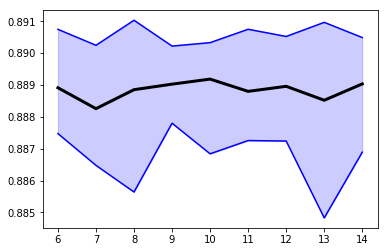

In [36]:
plt.plot(np.arange(6,15),res_mean,color='black',linewidth=3)
plt.plot(np.arange(6,15),res_up,color='blue')
plt.plot(np.arange(6,15),res_low,color='blue')
plt.fill_between(x=np.arange(6,15), y1=res_up, y2=res_low, alpha=0.2,color='blue')
plt.savefig('Nclasses.acc.pdf')

In [37]:
ll_mean = np.asarray(ll).mean(axis=0)
ll_up = np.quantile(np.asarray(ll),0.975, axis=0)
ll_low = np.quantile(np.asarray(ll),0.025, axis=0)

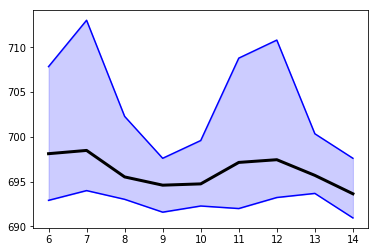

In [38]:
plt.plot(np.arange(6,15),ll_mean,color='black',linewidth=3)
plt.plot(np.arange(6,15),ll_up,color='blue')
plt.plot(np.arange(6,15),ll_low,color='blue')
plt.fill_between(x=np.arange(6,15), y1=ll_up, y2=ll_low, alpha=0.2,color='blue')
plt.savefig('Nclasses.ll.pdf')

In [40]:
Bcell = []
for x in batch_entropy:
    Bcell.append(x['B cells'])

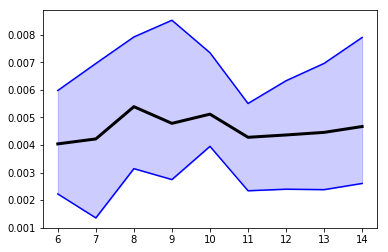

In [43]:
Bcell_mean = np.asarray(Bcell).mean(axis=0)
Bcell_up = np.quantile(np.asarray(Bcell),0.975, axis=0)
Bcell_low = np.quantile(np.asarray(Bcell),0.025, axis=0)

plt.plot(np.arange(6,15),Bcell_mean,color='black',linewidth=3)
plt.plot(np.arange(6,15),Bcell_up,color='blue')
plt.plot(np.arange(6,15),Bcell_low,color='blue')
plt.fill_between(x=np.arange(6,15), y1=Bcell_up, y2=Bcell_low, alpha=0.2,color='blue')
plt.savefig('Nclasses.Bcell.pdf')

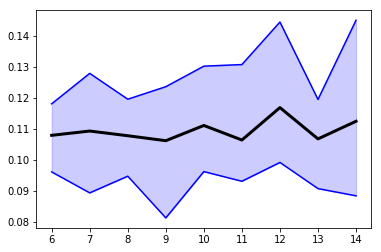

In [44]:
NKcell = []
for x in batch_entropy:
    NKcell.append(x['NK cells'])

NKcell_mean = np.asarray(NKcell).mean(axis=0)
NKcell_up = np.quantile(np.asarray(NKcell),0.975, axis=0)
NKcell_low = np.quantile(np.asarray(NKcell),0.025, axis=0)

plt.plot(np.arange(6,15),NKcell_mean,color='black',linewidth=3)
plt.plot(np.arange(6,15),NKcell_up,color='blue')
plt.plot(np.arange(6,15),NKcell_low,color='blue')
plt.fill_between(x=np.arange(6,15), y1=NKcell_up, y2=NKcell_low, alpha=0.2,color='blue')
plt.savefig('Nclasses.NKcell.pdf')

In [46]:
batch_entropy[0].keys()

dict_keys(['B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'CD4 T cells', 'Megakaryocytes', 'CD14+ Monocytes', 'Dendritic Cells'])

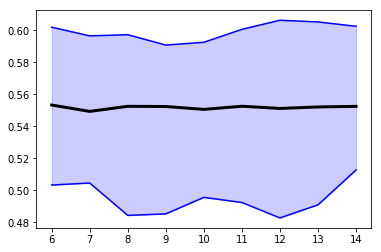

In [47]:
other = []
for x in batch_entropy:
    other.append(x['CD8 T cells'])
    other.append(x['FCGR3A+ Monocytes'])
    other.append(x['CD4 T cells'])
    other.append(x['CD14+ Monocytes'])

other_mean = np.asarray(other).mean(axis=0)
other_up = np.quantile(np.asarray(other),0.975, axis=0)
other_low = np.quantile(np.asarray(other),0.025, axis=0)

plt.plot(np.arange(6,15),other_mean,color='black',linewidth=3)
plt.plot(np.arange(6,15),other_up,color='blue')
plt.plot(np.arange(6,15),other_low,color='blue')
plt.fill_between(x=np.arange(6,15), y1=other_up, y2=other_low, alpha=0.2,color='blue')
plt.savefig('Nclasses.other.pdf')

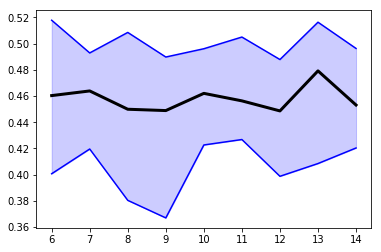

In [48]:
Dendritic = []
for x in batch_entropy:
    Dendritic.append(x['Dendritic Cells'])

Dendritic_mean = np.asarray(Dendritic).mean(axis=0)
Dendritic_up = np.quantile(np.asarray(Dendritic),0.975, axis=0)
Dendritic_low = np.quantile(np.asarray(Dendritic),0.025, axis=0)

plt.plot(np.arange(6,15),Dendritic_mean,color='black',linewidth=3)
plt.plot(np.arange(6,15),Dendritic_up,color='blue')
plt.plot(np.arange(6,15),Dendritic_low,color='blue')
plt.fill_between(x=np.arange(6,15), y1=Dendritic_up, y2=Dendritic_low, alpha=0.2,color='blue')
plt.savefig('Nclasses.Dendritic.pdf')

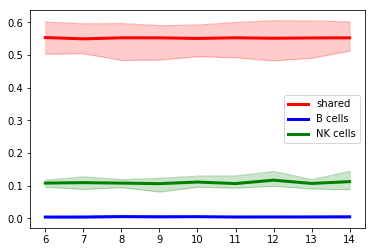

In [51]:
plt.plot(np.arange(6,15),other_mean,color='red',linewidth=3, label='shared')
plt.plot(np.arange(6,15),other_up,color='red',linewidth=0.1)
plt.plot(np.arange(6,15),other_low,color='red',linewidth=0.1)
plt.fill_between(x=np.arange(6,15), y1=other_up, y2=other_low, alpha=0.2,color='red')

plt.plot(np.arange(6,15),Bcell_mean,color='blue',linewidth=3, label='B cells')
plt.plot(np.arange(6,15),Bcell_up,color='blue',linewidth=0.1)
plt.plot(np.arange(6,15),Bcell_low,color='blue',linewidth=0.1)
plt.fill_between(x=np.arange(6,15), y1=Bcell_up, y2=Bcell_low, alpha=0.2,color='blue')

plt.plot(np.arange(6,15),NKcell_mean,color='green',linewidth=3, label='NK cells')
plt.plot(np.arange(6,15),NKcell_up,color='green',linewidth=0.1)
plt.plot(np.arange(6,15),NKcell_low,color='green',linewidth=0.1)
plt.fill_between(x=np.arange(6,15), y1=NKcell_up, y2=NKcell_low, alpha=0.2,color='green')

plt.legend()

plt.savefig('Nclasses.BE.pdf')